# BT2 - RANSAC y Transformada de Hough

## Autores

* **Juan Diego Gallego Nicolás (jdiego.gallego@um.es)**
* **Óscar Vera López (oscar.veral@um.es)**
  
## Fecha

**2 de Noviembre de 2025**

***

## Índice

### 1. Introducción al notebook

### 2. Configuración e inicialización

* 2.1. Importación de librerías
* 2.2. Definición de funciones auxiliares
* 2.3. Presentación y preprocesado de las imágenes

### Uso de IA

### Bibliografía

***

# 1. Introducción al notebook

Este notebook es la segunda parte de una serie de cinco que constituye nuestra práctica para la asignatura de Visión Artificial del Máster en Inteligencia Artificial de la Universidad de Murcia. Alguno de los métodos/resultados que aquí se utilizan pueden estar comentados en un notebook anterior. Para el correcto funcionamiento del mismo es necesario instalar el paquete del proyecto siguiendo las instrucciones del [repositorio de GitHub](https://github.com/oscarveral/vision.git).

Aquí tratamos la detección de rectas y de otras formas geométricas características en el ámbito de las señales de tráfico, candidatas idóneas sobre el papel para aplicar las técnicas vistas en la asignatura. Comenzamos presentando el conjunto de imágenes que servirán como objeto para la aplicación de **RANSAC** (Random Sample Consensus). Seguidamente pasamos a la preparación y transformación de las imágenes mediante la aplicación del pipeline propuesto e implementado en el notebook BT1 para el **operador de Canny**. También propinemos otro técnica de detección de bordes basado en la segmentación por color de las señales. Los siguientes puntos contienen la explicación y aplicación de nuestras implementaciones de RANSAC para la detección de rectas, segmentos y circunferencias. 

Al final del documento, incluimos un apartado de conclusiones y justificación de los ítems de bloques cubiertos por nuestro trabajo. También dejamos un párrafo explicando el papel de la IA generativa en la elaboración del mismo.

# 2. Configuración e inicialización

## 2.1. Importación de librerías

En el siguiente fragmento de código se incluyen las importaciones necesarias para la ejecución de todos los bloques de código del notebook. Recuerde crear un entorno virtual con el proyecto instalado (Ejecutar "pip install -e ." en el directorio raíz del proyecto) y seguir las instrucciones del fichero README.md.

In [1]:
# Imports de python

# Librerías de terceros
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import skimage.exposure as skie


# Librerías propias
from dgst.utils.loader import *
from dgst.utils.processor import *
from dgst.utils.features import *
from dgst.utils.fuser import *


## 2.2. Definición de funciones auxiliares

A continuación incluimos las definiciones de una serie de funciones para simplificar la salida de las celdas del notebook.

In [2]:
# Función para mostrar las imágenes en una cuadrícula
def plot_images(images, titles=None, grid_shape=(3, 4), figsize=None):
    if figsize is None:
        figsize = (grid_shape[1]*3, grid_shape[0]*2)
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i]
            if not isinstance(images[i], np.ndarray):
                image = images[i].get_image()
        
            if (image.ndim == 2):
                ax.imshow(image, cmap='gray')
            else:
                ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            if titles:
                ax.set_title(titles[i])
            else:
                ax.set_title(f'Image {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Función para mostrar las imágenes en una cuadrícula intercalando imágenes de diferentes listas
def intercalate_images(images_matrix, titles=None, grid_shape=(3, 4), figsize=None):
    intercalated_images = []
    intercalated_titles = []
    n_lists = len(images_matrix)
    n_images = len(images_matrix[0])
    idx = 0
    # Intercambiamos los índices para intercalar las imágenes
    for i in range(n_images):
        for j in range(n_lists):
            intercalated_titles.append(titles[j] + str(idx))
            intercalated_images.append(images_matrix[j][i])
        idx += 1

    plot_images(intercalated_images, intercalated_titles, grid_shape, figsize)

## 2.3. Presentación y preprocesado de las imágenes

Hemos seleccionado un subconjunto de 11 imágenes del dataset presentado en el notebook BT0. En todas las imágenes aparecen señales de tráfico con diferentes geometrías, algunas más cercanas a la cámara y otras más alejadas. Las encontramos dentro de la carpeta '/images/bt2'.



Loading image from ./images/bt2/000014/camera_front_blur/000014_india_2021-04-18T15:57:58.885517Z.jpg
Loading image from ./images/bt2/000177/camera_front_blur/000177_golf_2021-04-26T09:01:16.995578Z.jpg
Loading image from ./images/bt2/000205/camera_front_blur/000205_india_2021-04-29T13:26:40.774894Z.jpg
Loading image from ./images/bt2/000247/camera_front_blur/000247_golf_2021-04-27T10:58:38.108810Z.jpg
Loading image from ./images/bt2/020539/camera_front_blur/020539_india_2020-04-24T13:34:24.775134Z.jpg
Loading image from ./images/bt2/020541/camera_front_blur/020541_india_2020-03-31T11:09:20.113995Z.jpg
Loading image from ./images/bt2/020567/camera_front_blur/020567_india_2020-07-27T13:01:18.890907Z.jpg
Loading image from ./images/bt2/020578/camera_front_blur/020578_oscar_2021-04-15T08:41:33.109881Z.jpg
Loading image from ./images/bt2/020579/camera_front_blur/020579_india_2020-07-22T08:47:24.215579Z.jpg
Loading image from ./images/bt2/020604/camera_front_blur/020604_golf_2021-02-23T14:0

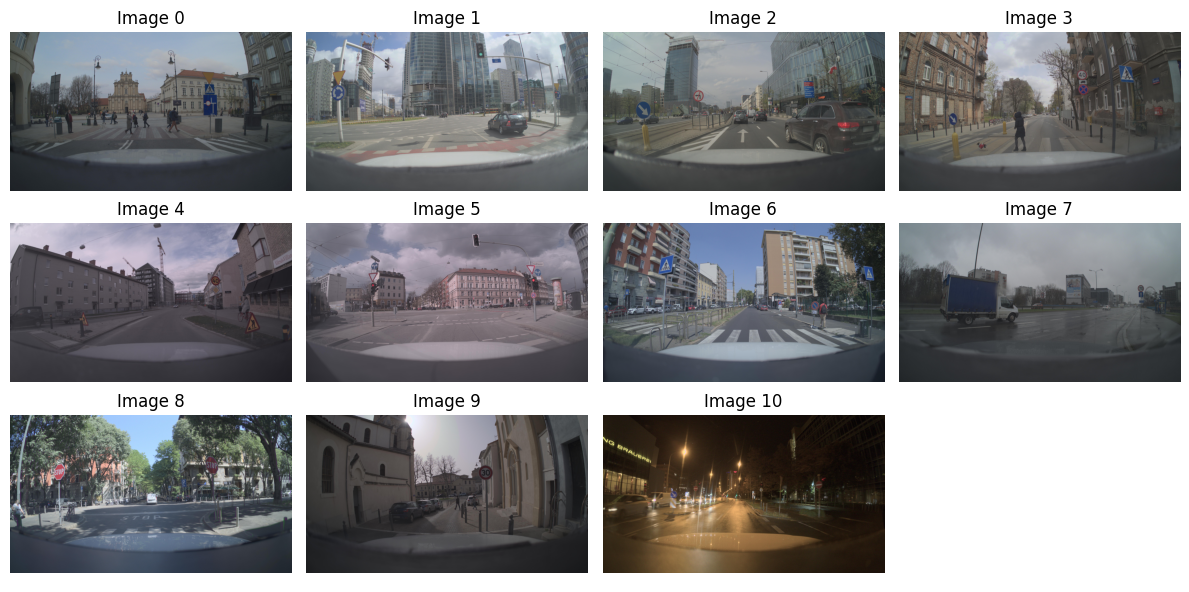

In [3]:
data_loader = DataLoader('./images/bt2')

images = []
for idx in [14, 177, 205, 247, 20539, 20541, 20567, 20578, 20579, 20604, 30352]:
    image = data_loader.load(idx)
    images.append(image)

plot_images(images, grid_shape=(3, 4), figsize=(12,6))

Como observamos, las imágenes sufren de una acusada distorsión de ojo de pez que ya comentamos en el notebook anterior. Este fenómeno dificultaría enormemente la aplicación de técnicas clasicas de detección de rectas. Por tanto, aplicamos el algoritmo de rectificación.

In [4]:
# Rectificamos las imágenes
rectified_images = []
for image in images:
    processor = (ImageProcessor()
        .add_kannala_brandt_undistortion()
    )
    rectified_image = processor.process(image)
    rectified_images.append(rectified_image)

print("Cada imagen rectificada tiene un tamaño de:", rectified_images[0].data.shape)

Cada imagen rectificada tiene un tamaño de: (2168, 3848, 3)


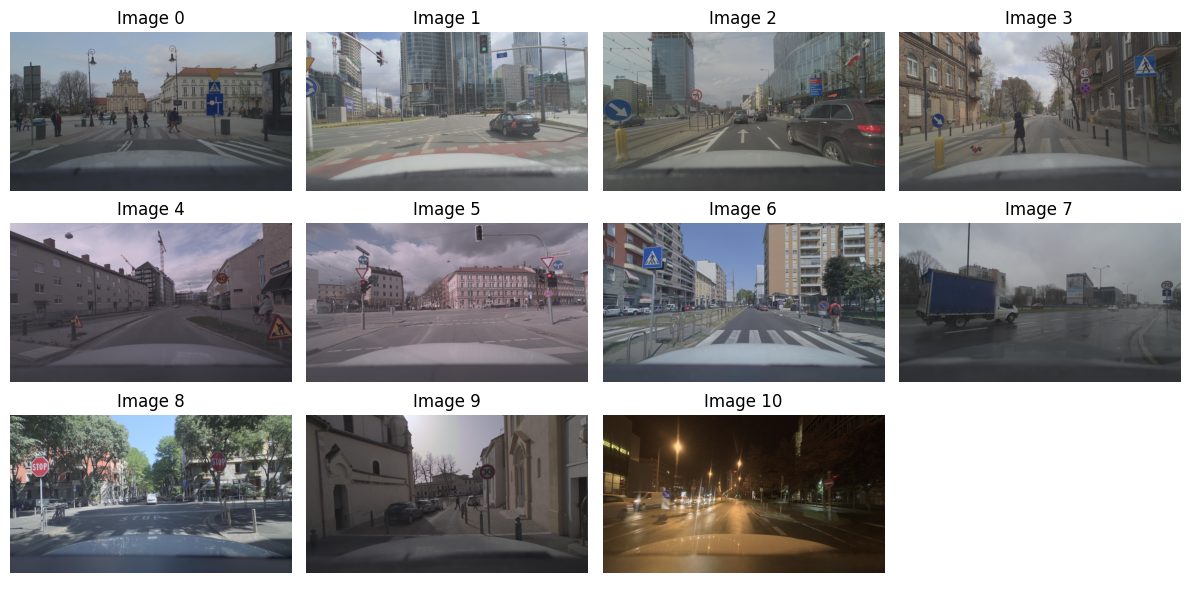

In [5]:
# Mostramos las imágenes rectificadas
plot_images(rectified_images, grid_shape=(3, 4))

El efecto es evidente, por ejemplo, en el salpicadero del coche. Otra consecuencia del filtro es la desaparición de los bordes de la imagen, aunque la resolución de las mismas se mantiene. 

Por motivos de eficiencia y para facilitar la visualización de los bordes posteriormente, reescalamos las imágenes en un factor de 0.5 mediante el algoritmo cv.INTER_AREA [[1]](#Bibliografía) de OpenCV, ideal para reducir imágenes.

In [6]:
images_scaled = []

processor = ImageProcessor().add_scale_inter_area(0.5)

for image in rectified_images:
    image = processor.process(image)
    images_scaled.append(image)

Una vez que contamos con las imágenes reducidas, aplicamos una reducción de ruido mediante un filtro de medianas, que mitiga el [ruido de sal y pimienta](https://en.wikipedia.org/wiki/Salt-and-pepper_noise) tan presente en las grabaciones de dashcams mientras preservamos bordes.

In [7]:
filtered_images = []

processor = ImageProcessor().add_median_blur(5)

for img in images_scaled:
    filtered_img = processor.process(img)
    filtered_images.append(filtered_img)

In [8]:
""" plot_images(filtered_images, grid_shape=(3, 4)) """

' plot_images(filtered_images, grid_shape=(3, 4)) '

Finalmente, renombranos la lista por comodidad y borramos todas las variables intermedias de la sección.

In [9]:
images = filtered_images

# 3. Detección de bordes

Antes de aplicar cualquier algoritmo de detección de formas geométricas es necesario usar en primer lugar un filtro de detección de bordes. En esta sección comparamos un filtro de bordes generalista clásico como lo puede ser el **operador de Canny** [[2]](#Bibliografía) visto en BT1 con una implementación basada en segmentación por color aprovechando la naturaleza del problema.

 HSV [[3]](https://en.wikipedia.org/wiki/HSL_and_HSV) alude a las siglas Hue/Saturation/Value. Las señales de tráfico son objetos que deben ser fácilmente detectados por el ojo humano, contando con colores característicos y saturados para diferenciarlos del entorno. Podemos visualizar la descomposición en dichos canales para alguna de nuestras imágenes:

In [10]:
processor = ImageProcessor().add_into_hsv_channels()
images_hsv = [processor.process(img) for img in images]

In [11]:
""" intercalate_images(
    images_matrix=[
        images,
        [img.get_hsv_channel('H') for img in images_hsv],
        [img.get_hsv_channel('S') for img in images_hsv],
        [img.get_hsv_channel('V') for img in images_hsv]
    ],
    titles=['Original Image ', 'Hue Channel ', 'Saturation Channel ', 'Value Channel '],
    grid_shape=(11, 4),
    figsize=(20, 40)
) """

" intercalate_images(\n    images_matrix=[\n        images,\n        [img.get_hsv_channel('H') for img in images_hsv],\n        [img.get_hsv_channel('S') for img in images_hsv],\n        [img.get_hsv_channel('V') for img in images_hsv]\n    ],\n    titles=['Original Image ', 'Hue Channel ', 'Saturation Channel ', 'Value Channel '],\n    grid_shape=(11, 4),\n    figsize=(20, 40)\n) "

Resulta evidente la importancia del canal de saturación a la hora de detectar las señales, pues destacan en la mayoría de los casos. También destaca el canal de matiz, que es divide la imagen por color, de forma que los tonos más oscuros y mas brillantes son rojos y los medios-altos son azules. El último canal, el de valor o brillo, es la clásica representación de la imagen en escala de grises.

La última imagen está escogida a drede para servir como posible caso de fallo para las técnicas que aquí aplicamos, pues es una imagen tomada de noche y muy saturada.


# 3.1. Operador de Canny

El detector de bordes de Canny [[2]](https://doi.org/10.1109/TPAMI.1986.4767851) es la herramienta más extendida en este ámbito dada su base matemática y su efectividad. En este notebook vamos a usar la implementación propia que comentábamos en el previo BT1. Como indicábamos, abarcamos desde la aplicación del filtro de Sobel para el cálculo de las derivadas direccionales y no aplica el filtro de suavizado previo. En la documentación de [OpenCV](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) no queda claro en qué magnitud aplica el filtro gaussiano, así que nosotros vamos a utilizar un kernel de $\sigma=0.4$ ya que es el que mejor nos funciona. 

Comenzamos declarando el procesador de imágenes que usaremos en esta sección.

In [12]:
""" canny_processor = (ImageProcessor()
    .add_clahe()
    .add_gaussian_filter(sigma=0.4, on_hsv=True)
    .add_canny_edge_detection(low_threshold=150, high_threshold=250, on_hsv=True)
    .add_dilate_edges(kernel_size=3, iterations=2, on_hsv=True)
) """

' canny_processor = (ImageProcessor()\n    .add_clahe()\n    .add_gaussian_filter(sigma=0.4, on_hsv=True)\n    .add_canny_edge_detection(low_threshold=150, high_threshold=250, on_hsv=True)\n    .add_dilate_edges(kernel_size=3, iterations=2, on_hsv=True)\n) '

Probamos el detecctor de canny sobre los tres canales HSV

In [13]:
""" canny_h = []
canny_s = []
canny_v = []
for img in images_hsv:
    res = canny_processor.process(img)
    canny_h.append(res.get_hsv_channel('H'))
    canny_s.append(res.get_hsv_channel('S'))
    canny_v.append(res.get_hsv_channel('V'))
 """

" canny_h = []\ncanny_s = []\ncanny_v = []\nfor img in images_hsv:\n    res = canny_processor.process(img)\n    canny_h.append(res.get_hsv_channel('H'))\n    canny_s.append(res.get_hsv_channel('S'))\n    canny_v.append(res.get_hsv_channel('V'))\n "

Y mostramos los resultados aplicando una pequeña dilatación para facilitar la visualización.

In [14]:
""" intercalate_images(
    images_matrix=[
        images,
        canny_h,
        canny_s,
        canny_v
    ],
    titles=['Original Image ', 'Canny on H Image ', 'Canny on S Image ', 'Canny on V Image '],
    grid_shape=(11, 4),
    figsize=(20, 40)
) """

" intercalate_images(\n    images_matrix=[\n        images,\n        canny_h,\n        canny_s,\n        canny_v\n    ],\n    titles=['Original Image ', 'Canny on H Image ', 'Canny on S Image ', 'Canny on V Image '],\n    grid_shape=(11, 4),\n    figsize=(20, 40)\n) "

Vemos como claramente el canal de saturación (S) es el que mejores resultados ofrece para la detección de bordes en las señales de tráfico, especialmente en las señales rojas y azules. El canal de matiz (H) también ofrece buenos resultados en algunas señales captando, por ejemplo, las señales de obras de la imagen 4; pero en general es menos consistente que el canal de saturación.

Podemos realizar una última prueba aplicando el filtro a una combinación ponderada de ambos canales:

In [15]:
""" img_hs = []
canny_hs = []
s_weight = 0.75

fuse_hs = ImageProcessor().add_channel_weight('H', 'S', s_weight)

canny_hs_proc = (ImageProcessor()
    .add_gaussian_filter(sigma=0.4)
    .add_canny_edge_detection(low_threshold=150, high_threshold=250)
    .add_dilate_edges(kernel_size=3, iterations=2)
)

for img in images_hsv:
    hs_channel = fuse_hs.process(img)
    img_hs.append(hs_channel)
    canny_mask_hs = canny_hs_proc.process(hs_channel)
    canny_hs.append(canny_mask_hs) """

" img_hs = []\ncanny_hs = []\ns_weight = 0.75\n\nfuse_hs = ImageProcessor().add_channel_weight('H', 'S', s_weight)\n\ncanny_hs_proc = (ImageProcessor()\n    .add_gaussian_filter(sigma=0.4)\n    .add_canny_edge_detection(low_threshold=150, high_threshold=250)\n    .add_dilate_edges(kernel_size=3, iterations=2)\n)\n\nfor img in images_hsv:\n    hs_channel = fuse_hs.process(img)\n    img_hs.append(hs_channel)\n    canny_mask_hs = canny_hs_proc.process(hs_channel)\n    canny_hs.append(canny_mask_hs) "

In [16]:
""" intercalate_images(
    images_matrix=[
        images,
        img_hs,
        canny_hs
    ],
    titles=['Original Image ', 'HS Combined Channel ', 'Canny on HS Channel '],
    grid_shape=(11, 3),
    figsize=(15, 40)
) """

" intercalate_images(\n    images_matrix=[\n        images,\n        img_hs,\n        canny_hs\n    ],\n    titles=['Original Image ', 'HS Combined Channel ', 'Canny on HS Channel '],\n    grid_shape=(11, 3),\n    figsize=(15, 40)\n) "

La proporción 25-75 es la que mejor balancea los artefactos detectados en cada uno de los parámetros probados.

Terminamos este apartado borrando lo que ya no vamos a usar y renombrando la lista de bordes de Canny.

In [17]:
""" img_hs = []
canny = []
s_weight = 0.75

fuse_hs = ImageProcessor().add_channel_weight('H', 'S', s_weight)

canny_hs_proc = (ImageProcessor()
    .add_gaussian_filter(sigma=0.4)
    .add_canny_edge_detection(low_threshold=150, high_threshold=250)
)

for img in images_hsv:
    hs_channel = fuse_hs.process(img)
    img_hs.append(hs_channel)
    canny_mask_hs = canny_hs_proc.process(hs_channel)
    canny.append(canny_mask_hs) """

" img_hs = []\ncanny = []\ns_weight = 0.75\n\nfuse_hs = ImageProcessor().add_channel_weight('H', 'S', s_weight)\n\ncanny_hs_proc = (ImageProcessor()\n    .add_gaussian_filter(sigma=0.4)\n    .add_canny_edge_detection(low_threshold=150, high_threshold=250)\n)\n\nfor img in images_hsv:\n    hs_channel = fuse_hs.process(img)\n    img_hs.append(hs_channel)\n    canny_mask_hs = canny_hs_proc.process(hs_channel)\n    canny.append(canny_mask_hs) "

## 3.2. Segmentación por color y dilatación

Otra forma que proponemos para la detección de bordes es la aplicación de una máscara binaria para la detección de los píxeles en el rango de color de las señales y una dilatación binaria de la misma. El procedimiento es el siguiente: 

In [18]:
# Filtramos las señales en las imágenes
# El método espera imágenes en espacio de color HSV
# Va a capturar señales rojas y azules, colores presentes en la mayoría de las señales de tráfico
signal_masks = []

color_procesor = (ImageProcessor().add_fuse_hsv_channels().add_red_blue_filter().add_filter_connected_components(min_size=20))

for img in images_hsv:
    signal_mask = color_procesor.process(img)
    signal_masks.append(signal_mask)


# Aplicamos dilatación para obtener los bordes de las señales detectadas

dilator = ImageProcessor().add_dilate_edges(kernel_size=3, iterations=1)
fuser = ImageFuser()

signal_borders = []
for mask in signal_masks:
    dilated = dilator.process(mask)
    sub = fuser.subtract(dilated, mask)
    signal_borders.append(sub)


In [19]:
""" intercalate_images(
    images_matrix=[
        images,
        signal_masks,
        signal_borders
    ],
    titles=['Original Image ', 'Signal Masks ', 'Signal Borders '],
    grid_shape=(11, 3),
    figsize=(15, 40) ) """

" intercalate_images(\n    images_matrix=[\n        images,\n        signal_masks,\n        signal_borders\n    ],\n    titles=['Original Image ', 'Signal Masks ', 'Signal Borders '],\n    grid_shape=(11, 3),\n    figsize=(15, 40) ) "

El resultado obtenido es tremendamente satisfactorio, funcionando incluso en la última imagen a pesar de sus problemas.

Almacenamos las máscaras en una lista con un nombre más sencillo.

In [20]:
borders = signal_borders

## 3.3. Comparación de los resultados

La segunda técnica de máscara+dilatación ha funcionado mucho mejor que la primera, detectando las señales de forma más precisa y completa.
A pesar de ser una técnica sencilla, los resultados son muy buenos y se adaptan bien a las imágenes del conjunto de datos.
Podemos ver una comparación de los resultados obtenidos con ambas técnicas y una intersección de las dos máscaras para ver las coincidencias y diferencias.

In [21]:
""" matches = []
union = []
for i in range(len(images)):
    match = fuser.bitwise_and(canny[i], borders[i])
    matches.append(dilator.process(match))
    union.append(dilator.process(fuser.bitwise_or(canny[i], borders[i])))
    borders[i] = dilator.process(borders[i]) """

' matches = []\nunion = []\nfor i in range(len(images)):\n    match = fuser.bitwise_and(canny[i], borders[i])\n    matches.append(dilator.process(match))\n    union.append(dilator.process(fuser.bitwise_or(canny[i], borders[i])))\n    borders[i] = dilator.process(borders[i]) '

In [22]:
""" intercalate_images(
    images_matrix=[
        images,
        matches,
        union,
        borders
    ],
    titles=['Original Image ', 'Canny & Borders Intersec ', 'Canny & Borders Union ', 'Borders '],
    grid_shape=(11, 4),
    figsize=(20, 40)) """


" intercalate_images(\n    images_matrix=[\n        images,\n        matches,\n        union,\n        borders\n    ],\n    titles=['Original Image ', 'Canny & Borders Intersec ', 'Canny & Borders Union ', 'Borders '],\n    grid_shape=(11, 4),\n    figsize=(20, 40)) "

Analizando los resultados obtenidos, el mejor detector de bordes para el dataset escogido es el propuesto en el apartado 3.2.

# 4. RANSAC

En esta sección explicamos y aplicamos nuestras implementaciones de RANSAC.


## 4.1. Implementación y aplicación de **RANSAC** para rectas

Una vez contamos con una imagen de bordes, la propuesta de RANSAC para la detección robusta de rectas es un algoritmo estadístico iterativo que funciona de la siguiente forma:

1. Se toman dos puntos de borde de forma aleatoria.
2. Se calcula la recta que pasa por esos dos puntos.
3. Se determina cuantos puntos del total están lo suficientemente cerca (inliers).
4. Si se supera cierto umbral de inliers, se considera que la recta es válida.

Este proceso se puede repetir estableciendo un número máximimo de iteraciones guardando el mejor modelo (el que más inliers tiene) o
hasta que se consiga un modelo con un buen número de inliers. Además, se puede reajustar la recta utilizando mínimos cuadrados sobre los inliners finales para conseguir una mayor precisión.

Nosotros hemos decidido implementar nuestra versión en C, la cual puede ser consultada en `src/dgst/ffi/ransac.c` bajo el nombre de **ransac_line_fitting**. El procedimiento implementado es el recién descrito, siendo el umbral de inliers un entero que acota por debajo la mínima cantidad de estos. Además, incluimos un parámetro _max_lsq_iterations_ que, si es mayor que 0, permite iniciar un proceso iterativo de ajuste de mínimos cuadrados sobre la recta obtenida mediante el proceso previo. Podemos ver su funcionamiento en la siguiente celda.

In [23]:
# Mapear a mapa booleano
booleanizer = ImageProcessor().add_into_boolean_mask()
for i in range(len(borders)):
    borders[i] = booleanizer.process(borders[i])

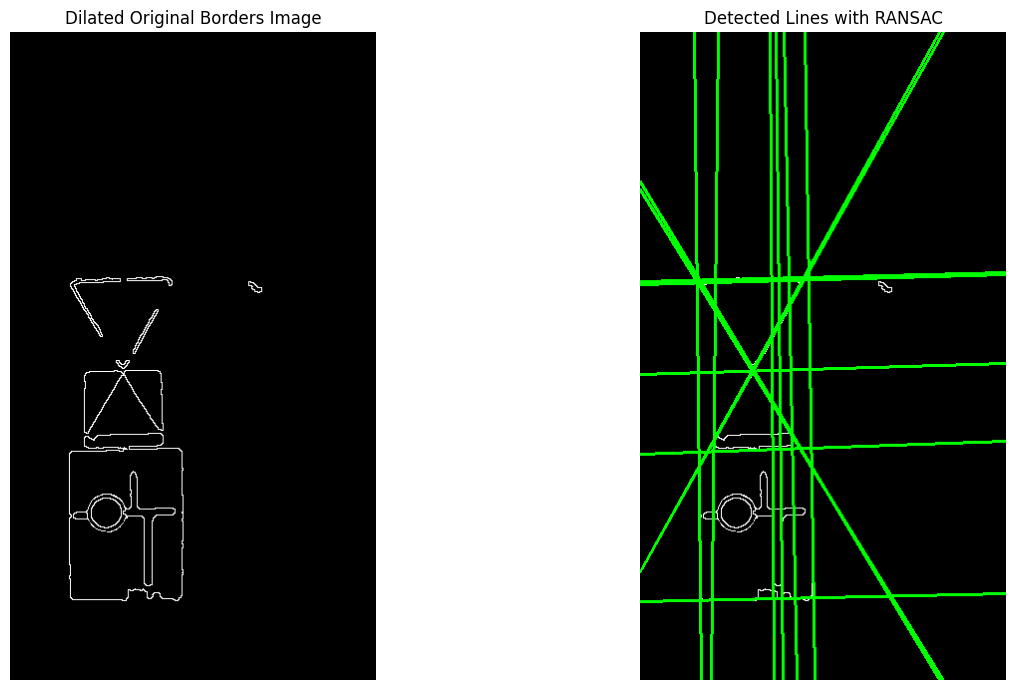

In [24]:
# Escogemos una imagen de bordes para aplicar RANSAC. Solo la mitad derecha.
clone = borders[0].clone()
borders_image = clone.data[0: int(clone.data.shape[0]*3/5), int(clone.data.shape[1]*2/3) : int(clone.data.shape[1]*6/7)]
clone.data = borders_image

# Instanciamos el extractor de características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=clone)

# Parámetros de iteración
min_inliers = 200
max_iterations = 70
iterations = 0

# Iteramos para encontrar más líneas
while iterations < max_iterations:
    feature_extractor.ransac_line_fitting(
        max_iterations=1000,
        distance_threshold=0.7,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=True
    )
    iterations += 1
    min_inliers = min_inliers - 2  # Reducimos el umbral de inliers para encontrar líneas más débiles

lines_image = feature_extractor.paint_lines_on_image(color=(0, 255, 0))

plot_images(
    [clone, lines_image],
    titles=['Dilated Original Borders Image', 'Detected Lines with RANSAC'],
    grid_shape=(1, 2),
    figsize=(15, 7)
)

Este ejemplo de uso funciona genial sobre esta sección de imagen en la que apreciamos una cantidad diferenciada de líneas rectas. Aplicando el mismo procedimiento sobre el conjunto de imágenes al completo tenemos el siguiente resultado.

In [25]:
border_lines = []

for img, i in zip(borders, range(len(borders))):
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.data.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

    # Parámetros de iteración
    min_inliers = 200
    max_nlines = 150

    # Iteramos para encontrar más líneas
    for j in range(0, max_nlines):
        feature_extractor.ransac_line_fitting(
            max_iterations=100,
            distance_threshold=0.7,
            min_inliers=min_inliers,
            max_lsq_iterations=1,
            erase=True
        )
        min_inliers = max(40, min_inliers - 1)  # Reducimos el umbral de inliers para encontrar líneas más débiles.

    lines_image = feature_extractor.paint_lines_on_image(color=(0, 255, 0))
    border_lines.append(lines_image)
    print(f"Processed image {i}: {len(feature_extractor._lines)} lines found")


Processed image 0: 14 lines found
Processed image 1: 4 lines found
Processed image 2: 21 lines found
Processed image 3: 5 lines found
Processed image 4: 12 lines found
Processed image 5: 3 lines found
Processed image 6: 26 lines found
Processed image 7: 26 lines found
Processed image 8: 18 lines found
Processed image 9: 0 lines found
Processed image 10: 6 lines found


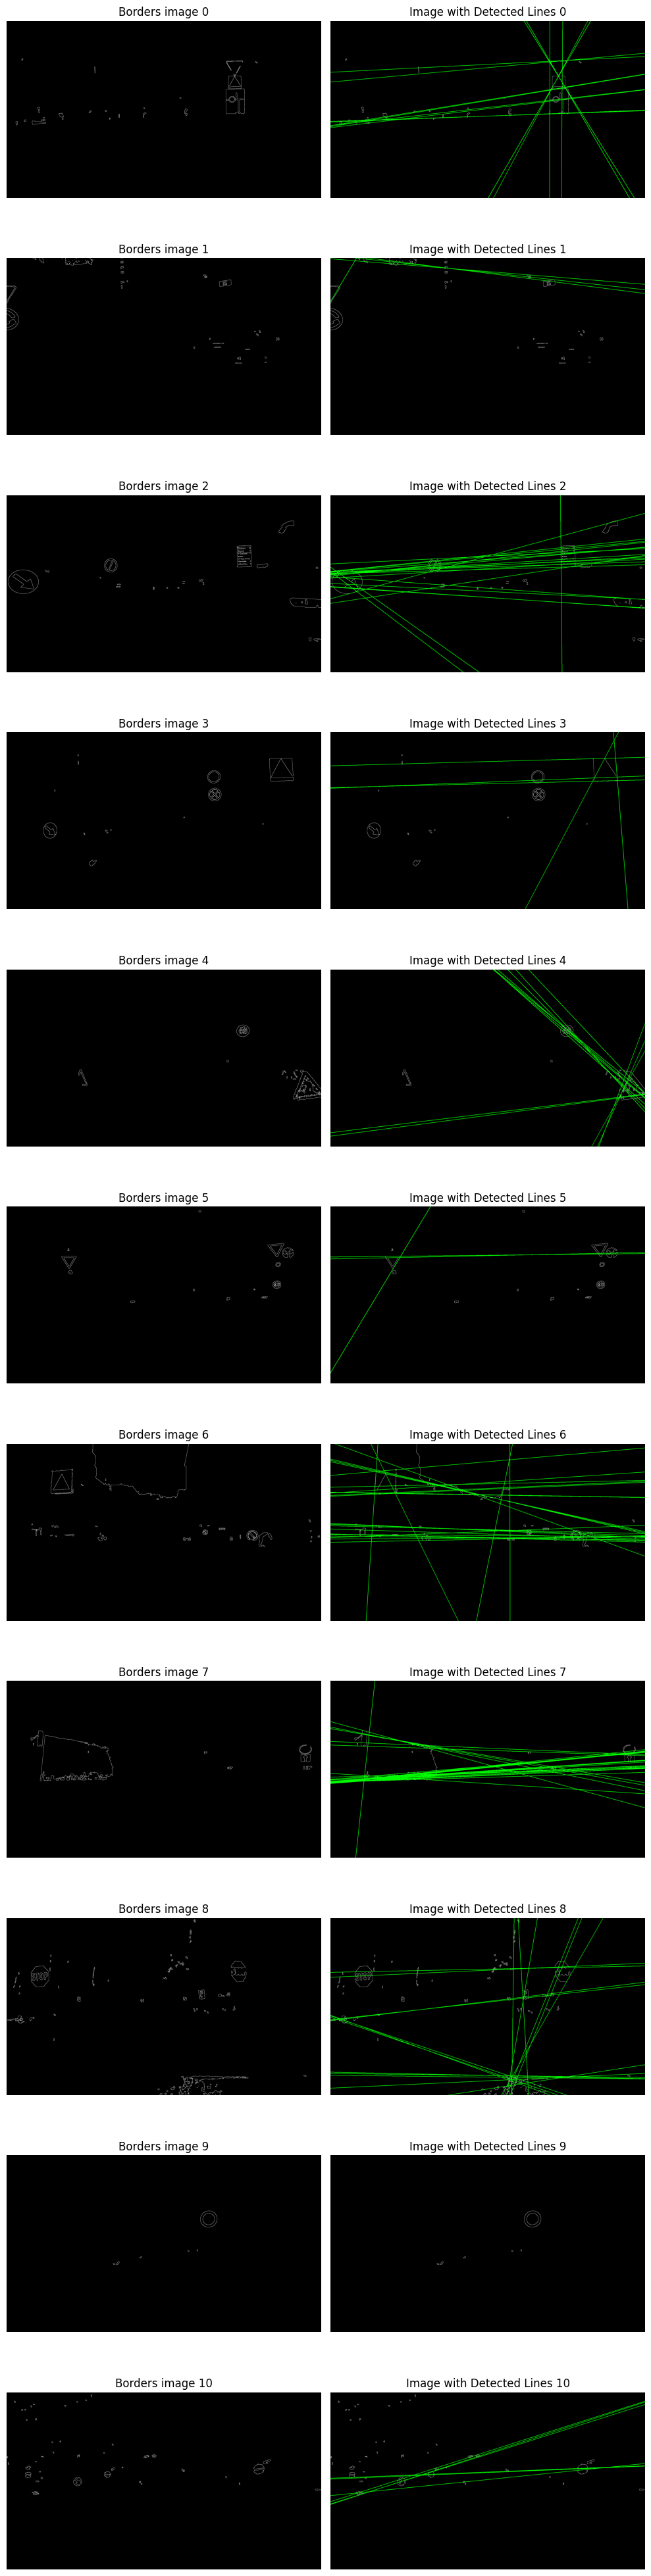

In [26]:
intercalate_images(
    images_matrix=[
        borders,
        border_lines
    ],
    titles=["Borders image ", 'Image with Detected Lines '],
    grid_shape=(11, 2),
    figsize=(10, 40)
)

Resulta que el algoritmo funciona perfectamente bien en imágenes con poco ruido y segmentos largos como en las imágenes 0, 3, 4 y 5. No obstante, en cuanto hay una cantidad no demasiado alta de nubes de puntos alineados las rectas encontradas son un sinsentido. Para solucionar esto y debido a que las señales de tráfico ocupan una sección relativamente pequeña de la imagen, proponemos aplicar RANSAC mediante un algoritmo de ventana deslizante. De esta forma, permitimos eliminar esas rectas que se ajustan al ruido y detectar bordes más pequeños al poder reducir el número mínimo de inliers necesarios para determinar una recta. Para ello, utilizamos un nuevo método extractor de características llamado _windowed_ransac_line_fitting_.

En la siguiente celda mostramos el resultado de aplicar este algoritmo con un tamaño de ventana ocho veces más pequeño que el alto de la imagen, con un paso de la mitad del tamaño de ventana y con un número mínimo de inliers de la mitad del tamaño de ventana.

Iteration 1: 14 lines found.
Iteration 2: 4 lines found.
Iteration 3: 0 lines found.
Iteration 4: 0 lines found.
Iteration 5: 0 lines found.
18 lines detected.


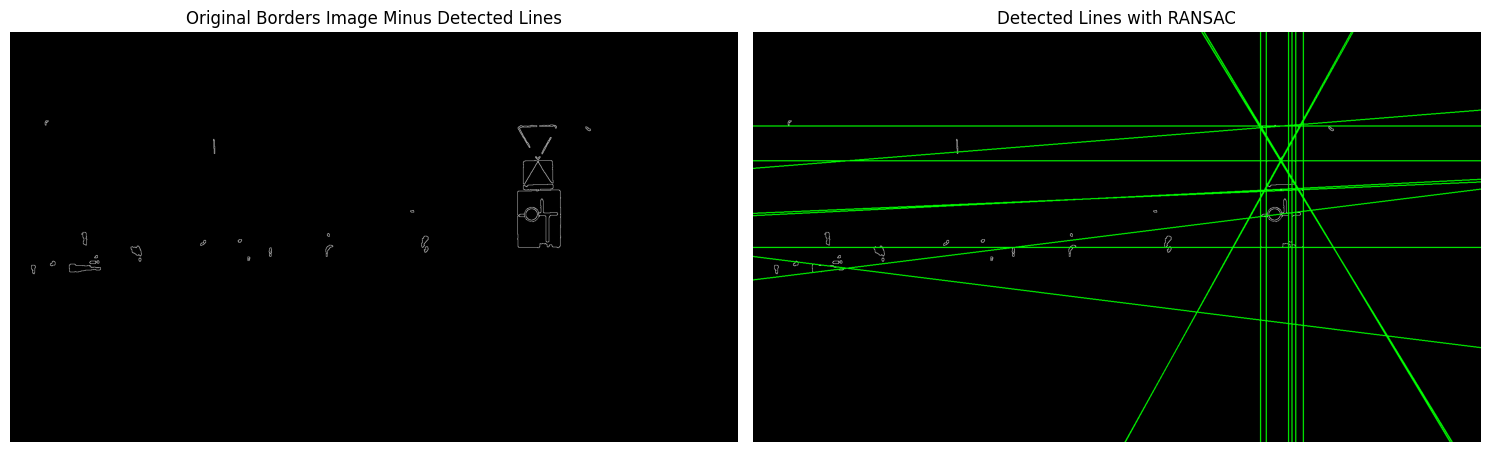

In [27]:
# Escogemos una imagen de bordes para aplicar RANSAC
img = borders[0]

# Instanciamos el extractor de características con la imagen de bordes (binaria).
feature_extractor = FeatureExtractor(edge_image=img)

# Definimos el tamaño de la ventana
window_size = min(img.data.shape[0], img.data.shape[1])//8
step = window_size//2
min_inliers = window_size//2
n_lines = 0

for i in range(0,5):
    lines = feature_extractor.windowed_ransac_line_fitting(
        window_size=window_size,
        step=step,
        max_iterations=100,
        distance_threshold=1.0,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=True
    )
    # Adjust min_inliers if no new lines were found.
    if len(lines) == len(feature_extractor._lines):
        min_inliers = max(0, min_inliers - window_size//20)
    print(f"Iteration {i+1}: {len(lines)} lines found.")

print(len(feature_extractor._lines), "lines detected.")

lines_image = feature_extractor.paint_lines_on_image(color=(0, 255, 0))

plot_images(
    [img, lines_image],
    titles=['Original Borders Image Minus Detected Lines', 'Detected Lines with RANSAC'],
    grid_shape=(1, 2),
    figsize=(15, 7)
)

En este caso la detección de rectas es tremendamente buena. En la imagen de la izquierda podemos ver el resultado de sustraer las rectas encontradas en la imagen a la imagen de bordes original y observamos que los bordes originales de las señales han prácticamente desaparecido. Si hacemos lo mismo para todo el conjunto de imágenes:

In [28]:
border_lines = []
for img, i in zip(borders, range(len(borders))):
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.data.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))
    window_size = min(img.data.shape[0], img.data.shape[1])//8
    step = window_size//2
    min_inliers = window_size//2
    
    for j in range(0,10):
        lines = feature_extractor.windowed_ransac_line_fitting(
            window_size=window_size,
            step=step,
            max_iterations=100,
            distance_threshold=0.4,
            min_inliers=min_inliers,
            max_lsq_iterations=0,
            erase=True
        )
        if len(lines) == len(feature_extractor._lines):
            min_inliers = max(window_size//4, min_inliers - window_size//20)

    lines_image = feature_extractor.paint_lines_on_image(color=(0, 255, 0))
    border_lines.append(lines_image)
    print(f"Processed image {i}: {len(feature_extractor._lines)} lines found")
    

Processed image 0: 10 lines found
Processed image 1: 1 lines found
Processed image 2: 6 lines found
Processed image 3: 7 lines found
Processed image 4: 3 lines found
Processed image 5: 7 lines found
Processed image 6: 10 lines found
Processed image 7: 1 lines found
Processed image 8: 2 lines found
Processed image 9: 0 lines found
Processed image 10: 1 lines found


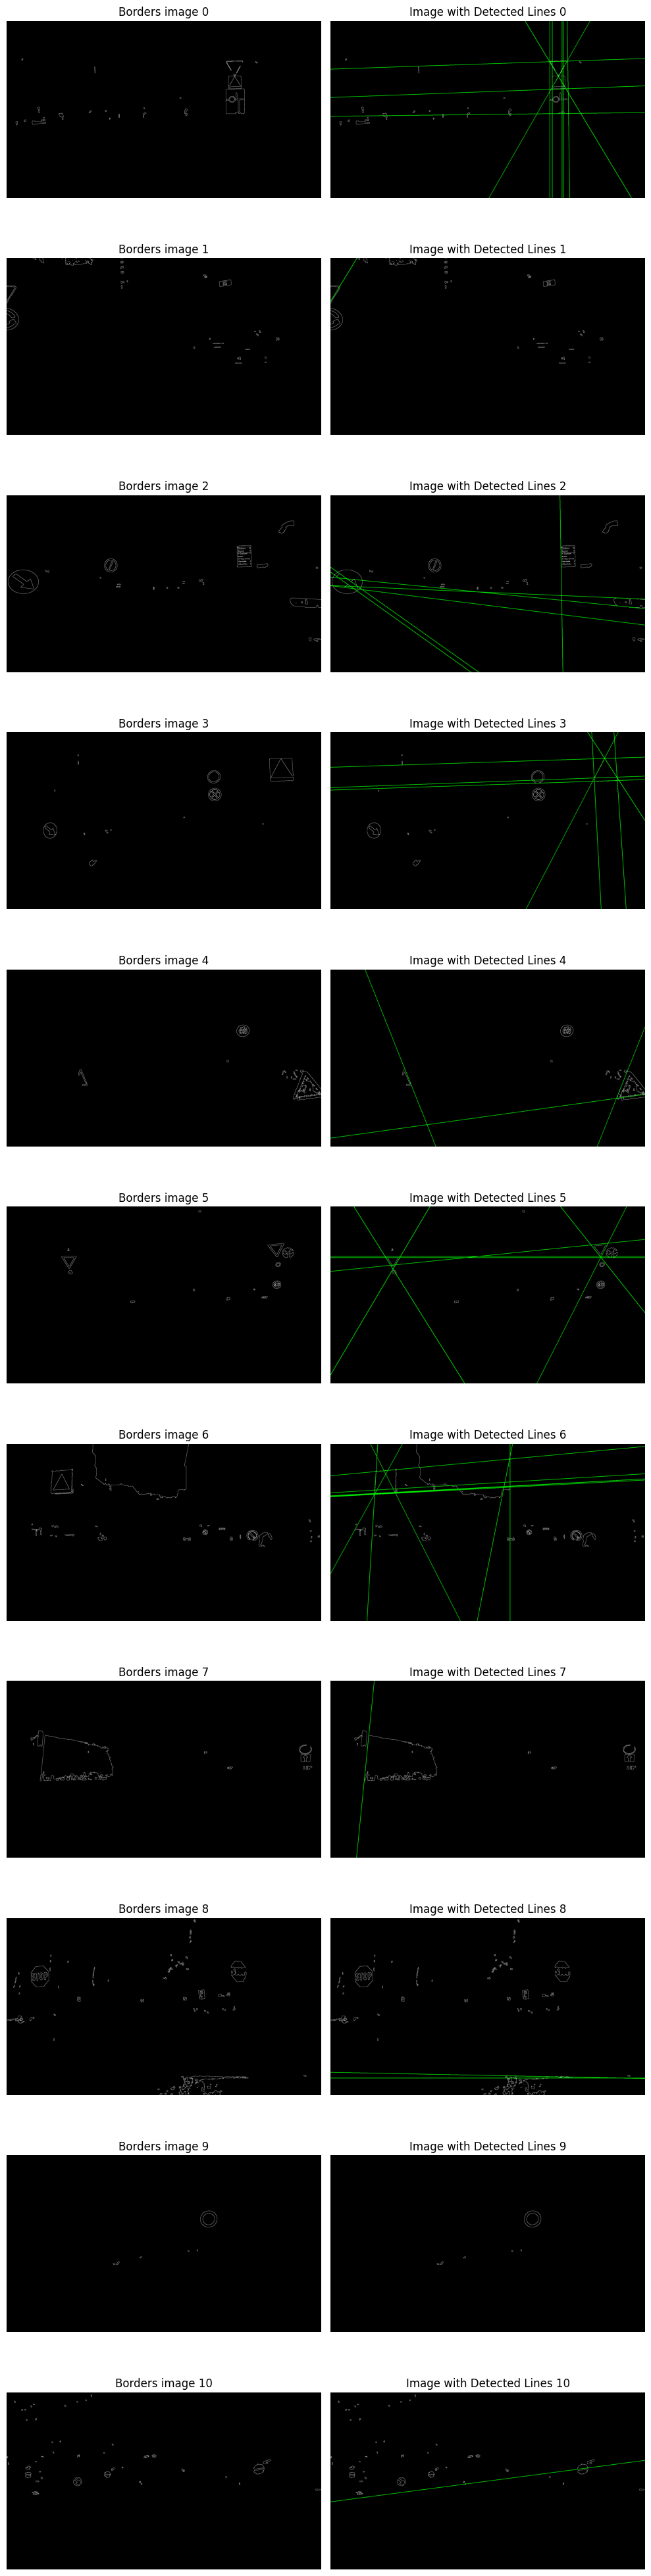

In [29]:
intercalate_images(
    images_matrix=[
        borders,
        border_lines
    ],
    titles=["Borders image ", 'Image with Detected Lines '],
    grid_shape=(11, 2),
    figsize=(10, 40)
)

Claramente, la detección de líneas mediante RANSAC con ventanas deslizantes mejora la robustez frente a variaciones locales en la imagen. 
Al ajustar parámetros como el tamaño de la ventana, el umbral de inliers y la distancia máxima, podemos optimizar la detección para diferentes líneas. No obstante, nubes de falsos positivos muy cercanos siguen dando problemas, como vemos en la imagen 7, y segmentos muy pequeños pasan desapercibidos, como es el caso de las señales de stop de la 8.

## 4.2. Detección de segmentos

Otro problema de la baja ocupancia de las señales en las imágenes es que las rectas cubren innecesariamente toda la imagen. 
Sería ideal limitar la expresión de las mismas a los segmentos donde realmente hay señales.
Es por esto que proponemos un método para detectar segmentos a partir de las rectas detectadas. El procedimiento, 
implementado mediante el método _get_line_support_ de la clase FeatureExtractor, es el siguiente:
1. Se proporciona una recta en forma ax + by + c = 0, desactivando la eliminación de inliers tras la detección.
2. Se reobtienen los inliers de la línea en la imagen de bordes.
3. Los inliers se proyectan ortogonalmente sobre la recta para obtener sus coordenadas 1D.
4. Se calcula la densidad de inliers a lo largo de la línea.
5. Se identifica el segmento maximal con densidad que supere un umbral dado.

Para llevar a cabo el último paso, hemos utilizado una versión adaptada del [Algoritmo de Kadane](https://medium.com/@rsinghal757/kadanes-algorithm-dynamic-programming-how-and-why-does-it-work-3fd8849ed73d), un algoritmo de programación dinámica que resuelve el 
problema **Maximum Subarray Problem** de encontrar un subarray de suma máxima. Los pasos de esta adaptación son, partiendo de una serie de puntos en 1D (proyecciones sobre la recta):
1. Se construye un array auxiliar A, de forma que A[i] representa la contribucón de densidad del i-ésimo intervalo $A_i = 1 - \mu\times(p_{i+1} - p_i)$
2. Se recorre el array A guardando sus sumas acumuladas.
    
    2.1. Si el valor acumulado es el mejor hasta ahora, se almacena el intervalo.
    2.2. Si el valor acumulado es negativo, se empieza a contar de cero.

3. Se devuelve segmento maximal.

Una de las bondades de este algoritmo es que funciona en tiempo lineal con respecto al número de inliers. Podemos verlo en acción:




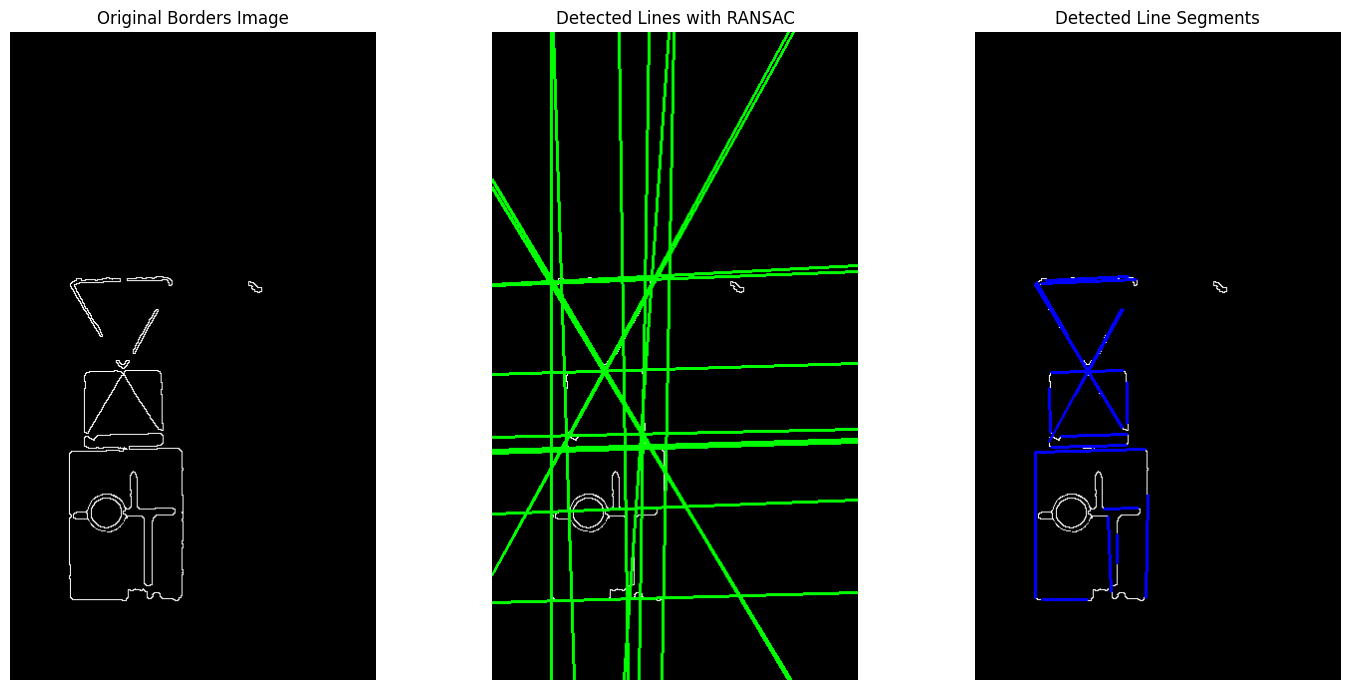

In [30]:
# Escogemos una imagen de bordes para aplicar RANSAC. Solo la mitad derecha
clone = borders[0].clone()
img = clone.data[0: int(clone.data.shape[0]*3/5), int(clone.data.shape[1]*2/3) : int(clone.data.shape[1]*6/7)]
clone.data = img

# Instanciamos el extractor de características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=clone)

# Parámetros de iteración
min_inliers = 200
max_nsegments = 150

# Iteramos para encontrar más líneas
for i in range(0, max_nsegments):
    line = feature_extractor.ransac_line_fitting(
        max_iterations=100,
        distance_threshold=0.7,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=False
    )
    if (line is not None):
        lines.append(line)
        segment = feature_extractor.get_line_support(
            line=line,
            distance_threshold=1.0,
            density_threshold=0.7,
            erase=True
        )

    min_inliers = max(min_inliers - 2, 40)  # Reducimos el umbral de inliers para encontrar líneas más débiles

lines_image = feature_extractor.paint_lines_on_image(color=(0, 255, 0))
segments_image = feature_extractor.paint_segments_on_image(color=(255, 0, 0))


plot_images(
    [img, lines_image, segments_image],
    titles=['Original Borders Image', 'Detected Lines with RANSAC', 'Detected Line Segments'],
    grid_shape=(1, 3),
    figsize=(15, 7)
)

En azul vemos los segmentos correspondientes a las rectas detectadas. Para sucesivas aplicaciones de este método creamos una nueva opción de extracción de features llamada _ransac_segment_fitting_ que unifica el proceso de detección de rectas con RANSAC y el cálculo del soporte. Con el parámetro erase controlamos varios escenarios:
- Si erase==False o si no se encuentra ninguna recta la imagen no se ve modificada.
- Si erase==True y se encuentra una recta sin suficiente soporte, se borra toda la recta.
- Si erase==True y se encuentra una recta con suficiente soporte, solo se borra la parte correspondiente al segmento. Así se evita borrar segmentos que pertenezcan a la misma recta por casualidad.
También establecemos una longitud mínima de segmento para filtrar rectas que unen nubes de ruido.

25 lines detected.
24 segments detected.


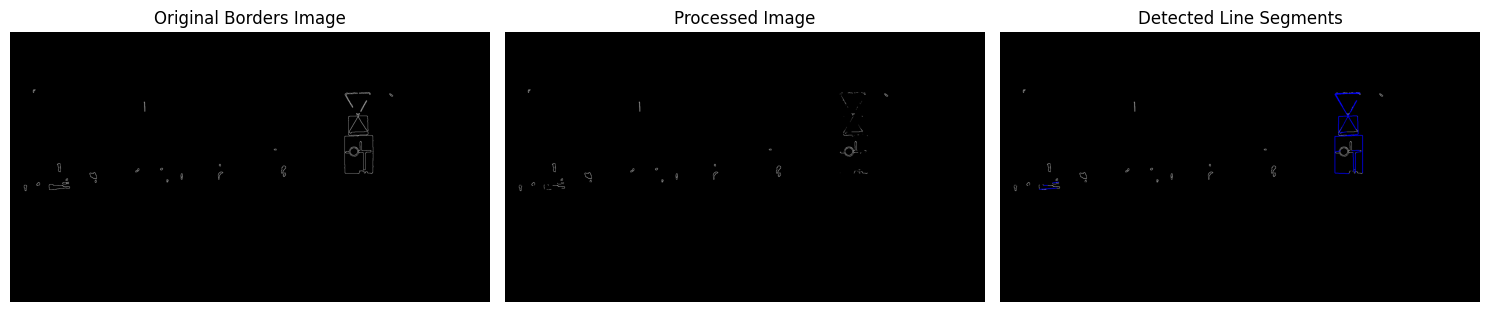

In [31]:
# Escogemos una imagen de bordes para aplicar RANSAC. Solo la mitad derecha
img = borders[0]

# Instanciamos el extractor de características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=img)

# Parámetros de iteración
min_inliers = 150
max_nsegments = 500
min_segment_length = 15

# Iteramos para encontrar más segmentos
for i in range(0, max_nsegments):
    feature_extractor.ransac_segment_fitting(
        max_iterations=200,
        distance_threshold_line=0.7,
        distance_threshold_segment=1.0,
        density_threshold=0.5,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        min_segment_length=min_segment_length,
        erase=True
    )
    if (i % 10) == 0:
        min_inliers = max(40, min_inliers - 2)  # Reducimos el umbral de inliers para encontrar líneas más débiles

print(len(feature_extractor._lines), "lines detected.")
print(len(feature_extractor._segments), "segments detected.")
segments_image = feature_extractor.paint_segments_on_image(color=(255, 0, 0))

plot_images(
    [borders[0], feature_extractor._edge_image, segments_image],
    titles=['Original Borders Image', 'Processed Image', 'Detected Line Segments'],
    grid_shape=(1, 3),
    figsize=(15, 7)
)

In [43]:
borderless_images = []
segments_images = []

for img in borders:
    # Instanciamos el extractor de características con la imagen de bordes (binaria)
    feature_extractor = FeatureExtractor(edge_image=img)

    # Parámetros de iteración
    min_inliers = 150
    max_nsegments = 500
    min_segment_length = 15

    # Iteramos para encontrar más segmentos
    for i in range(0, max_nsegments):
        feature_extractor.ransac_segment_fitting(
            max_iterations=200,
            distance_threshold_line=0.7,
            distance_threshold_segment=1.0,
            density_threshold=0.5,
            min_inliers=min_inliers,
            max_lsq_iterations=0,
            min_segment_length=min_segment_length,
            erase=True
        )
        if (i % 10) == 0:
            min_inliers = max(40, min_inliers - 2)  # Reducimos el umbral de inliers para encontrar líneas más débiles

    segments_image = feature_extractor.paint_segments_on_image(color=(255, 0, 0))
    segments_images.append(segments_image)
    borderless_images.append(feature_extractor._edge_image.clone())

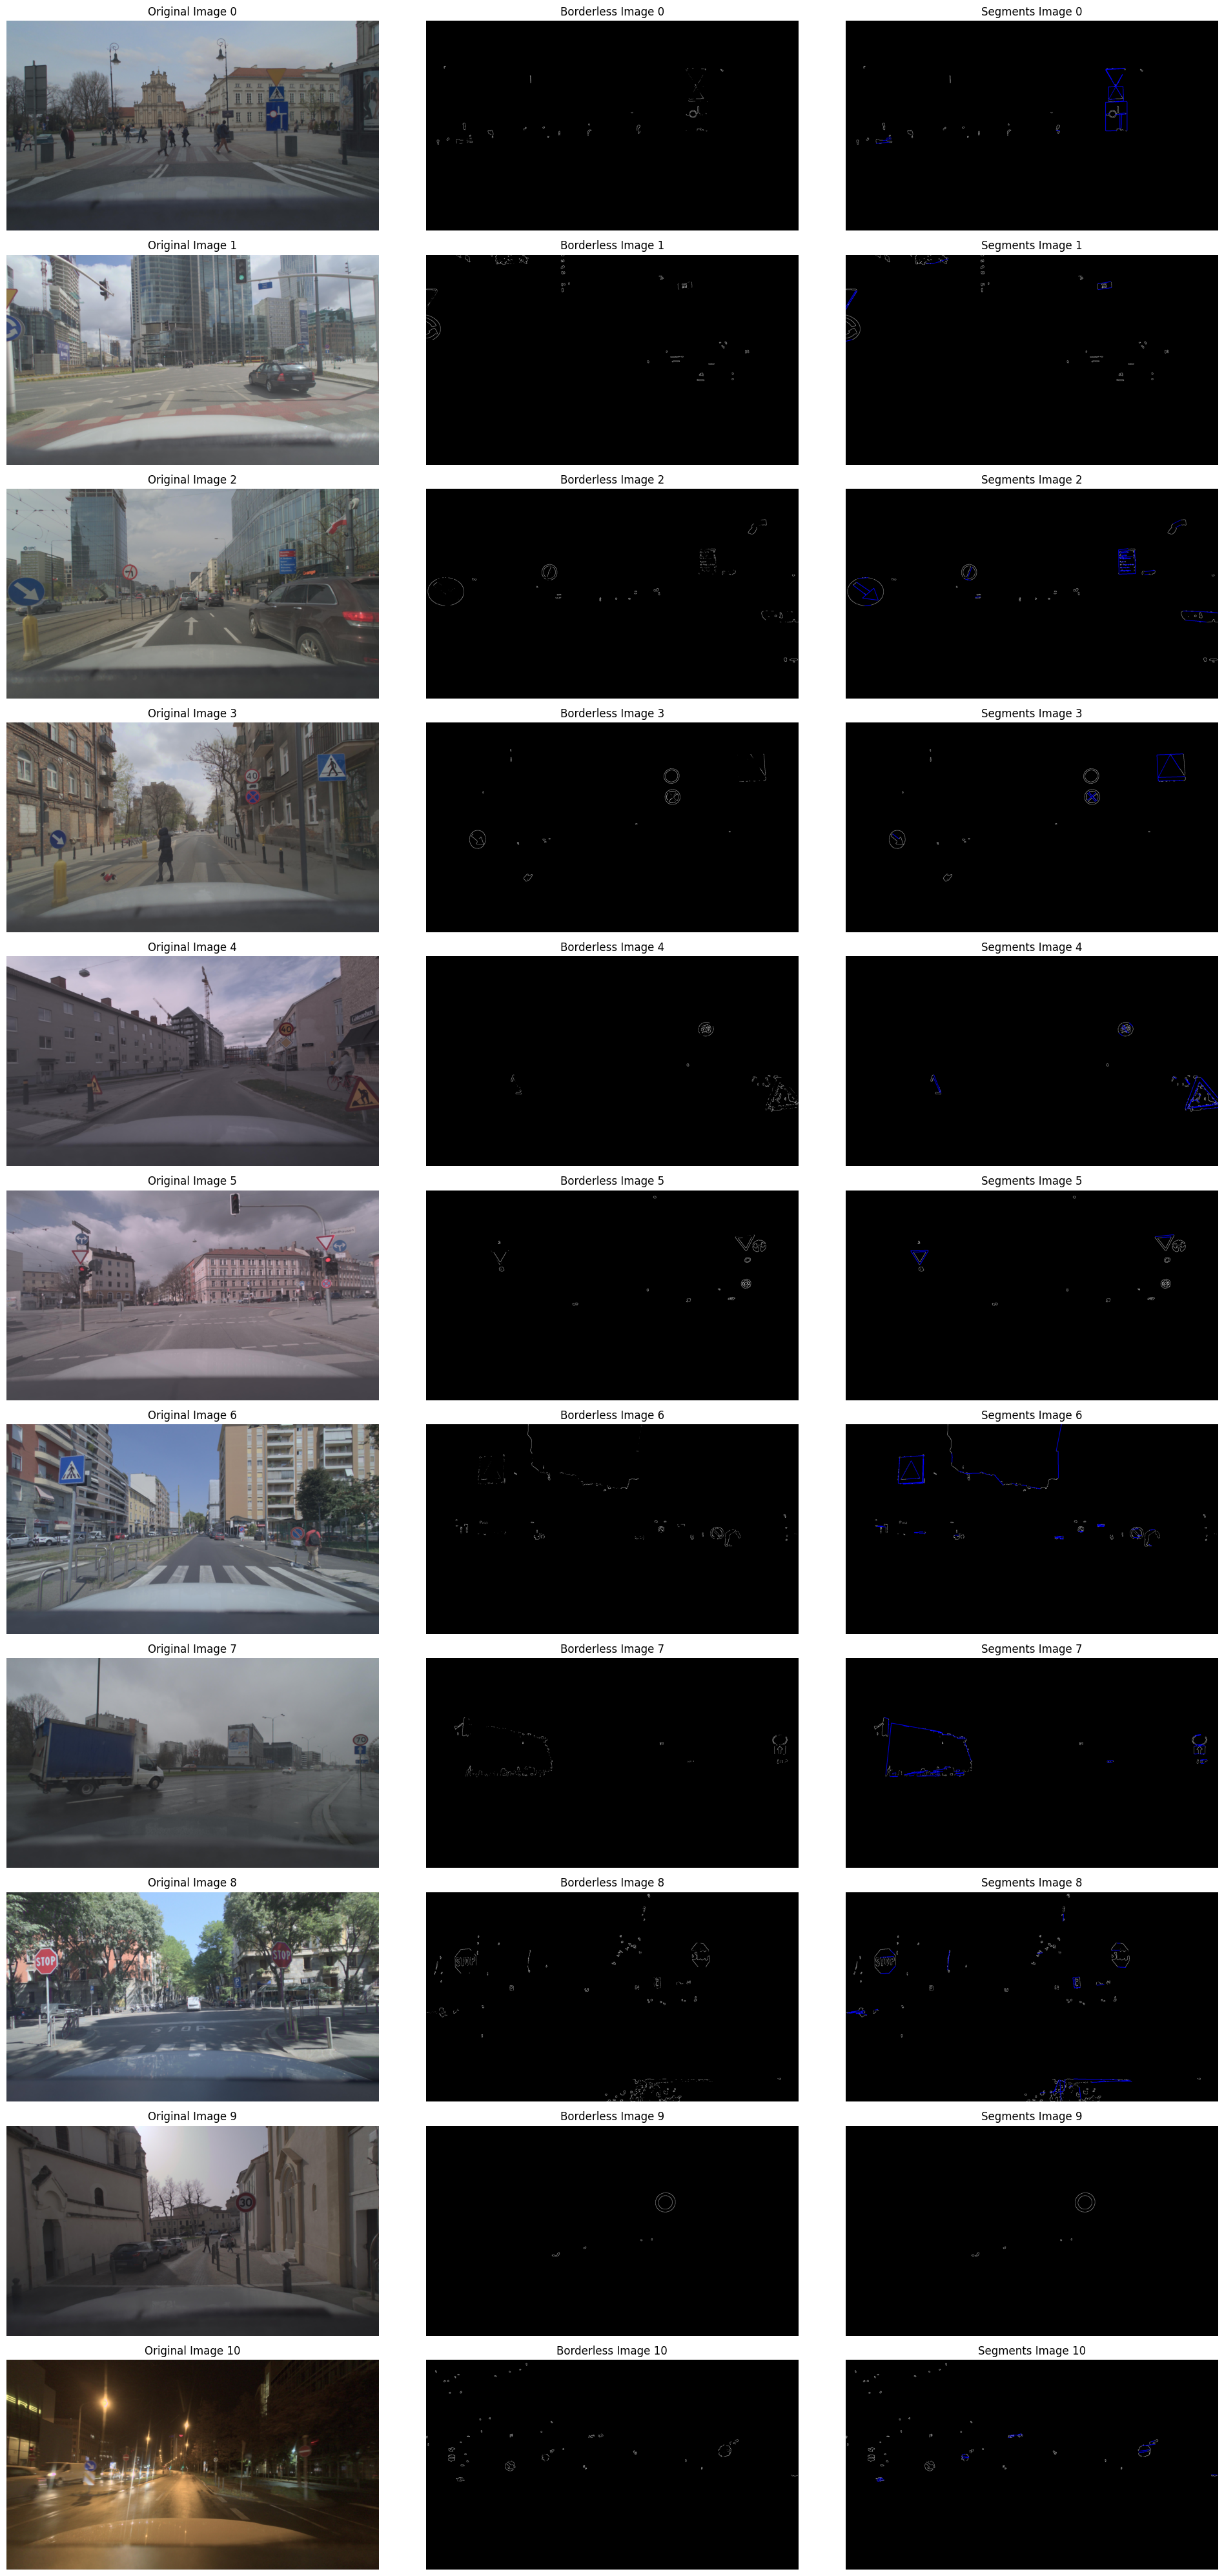

In [45]:
# Mostrar resultados
intercalate_images(
    images_matrix=[
        images,
        borderless_images,
        segments_images,
    ],
    titles=['Original Image ', 'Borderless Image ', 'Segments Image '],
    grid_shape=(11, 3),
    figsize=(20, 40)
) 

## Bibliografía

[1] Open Source Computer Vision Library, “Geometric Image Transformations,” in OpenCV 3.4.20-dev Documentation, [En línea]. Disponible: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html [Consultado: 02-Nov-2025]

[2] [Canny, J. (1986)](https://doi.org/10.1109/TPAMI.1986.4767851). *A Computational Approach to Edge Detection.* **IEEE Transactions on Pattern Analysis and Machine Intelligence**, vol. PAMI-8, no. 6, pp. 679–698, Nov. 1986.

[3] Wikipedia, "Modelo de color HSV", Wikipedia, la enciclopedia libre, [En línea]. Disponible: https://es.wikipedia.org/wiki/Modelo_de_color_HSV. [Consultado: 30-Oct-2025].
